In [ ]:
from pathlib import Path

repo_url  = 'https://github.com/ucabres/Kernel-ODE'
project_path        = Path('/').absolute() / 'content'
kernelode_repo_path = project_path / 'KernelODEsAdversarial'

# Create project folder if inexistant
if not project_path.is_dir():
    %mkdir "{project_path}"
%cd "{project_path}"

# Download repository
!git config --global user.name "ucabres"
!git config --global user.email "ucabres@ucl.ac.uk"
if kernelode_repo_path.is_dir():
    !git -C "{kernelode_repo_path}" fetch origin
    !git -C "{kernelode_repo_path}" checkout origin/main -- *.py
else:
    print("Install repository")
    !git clone {repo_url}

/content
Install repository
Cloning into 'KernelODEsAdversarial'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 91 (delta 29), reused 72 (delta 13), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [ ]:
%cd KernelODEsAdversarial/

/content/KernelODEsAdversarial


In [ ]:
!git clone 'https://github.com/cambridge-mlg/cnn-gp'

Cloning into 'cnn-gp'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 365.64 KiB | 12.61 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
%cd cnn-gp
%pip install -e .
%cd ..

/content/KernelODEsAdversarial/cnn-gp
Obtaining file:///content/KernelODEsAdversarial/cnn-gp
  Running setup.py develop for cnn-gp
/content/KernelODEsAdversarial


In [ ]:
%pip install -r requirements.txt

     |████████████████████████████████| 678 kB 20.7 MB/s 


In [ ]:
%pip install -e .

Obtaining file:///content/KernelODEsAdversarial
  Running setup.py develop for KernelODEsAdversarial


In [ ]:
import os
import matplotlib.pyplot as plt

import torch
import torchvision

from kernelode.kernel_ode import ODEKernel, ode_kernel
from kernelode.utils import predict_class_vector, predict_class

import torch.nn.functional as F

In [ ]:
batch_size_train = 512
batch_size_test = 256
num_classes = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_test, shuffle=True)


train_examples = enumerate(train_loader)
batch_idx, (train_example_data, train_example_targets) = next(train_examples)

test_examples = enumerate(test_loader)
batch_idx, (test_example_data, test_example_targets) = next(test_examples)

### Conv Kernel

In [ ]:
%cd cnn-gp/

/content/KernelODEsAdversarial/cnn-gp


In [ ]:
import os
import matplotlib.pyplot as plt

import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn.module import PyroParam


from torchdiffeq import odeint
from math import pi


from cnn_gp import Sequential, Conv2d, ReLU

π = torch.tensor(pi)

model = Sequential(
    Conv2d(kernel_size=4, stride=2),
    ReLU(),
    Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
)

def ode_conv_kernel(X,Y, σ_b, σ_w, n=500.0,dim=1,method='euler', atol=0.01, rtol=1e-4, same=False):
    #  Model: dk /dt = f(t, k )  where k is the kernel matrix   
    
    X = X.reshape(-1,1,28,28)
    Y = Y.reshape(-1,1,28,28)

    ts = torch.tensor([0, 1.0])
    dt = 1.0 / n # Uniform scaling

    y0 = σ_b**2 + 0.5 * σ_w**2 * model(X, Y, same=same)

    def f(γ):
        ϵ = 1e-6
        γ = ϵ + (1 - 2 * ϵ) * torch.clip(γ,-1,1)
        
        return (1.0 / π) * (torch.sqrt(1.0 - γ**2) - γ * torch.arccos(γ))

    def k_xx_t_x(t,X_):
        k0 = σ_b**2 + 0.5 * σ_w**2 * model(X_, diag=True)
        result = torch.exp(0.5 * σ_w**2 * t) * k0 + 2 * (σ_b**2 / σ_w**2) * (torch.exp(0.5 * σ_w**2 * t) - 1.0)
        return result
   
    k_xx_t_ = lambda t: k_xx_t_x(t,X)
    k_yy_t_ = lambda t: k_xx_t_x(t,Y)
    
    def c_t(t,k):
        kxxt = k_xx_t_(t).reshape(-1,1)
        kyyt = k_yy_t_(t).reshape(-1,1)

        result = k / torch.sqrt(kxxt.mm(kyyt.T))
        return result

    def drift(t,k):
        ct = c_t(t,k)

        result = σ_b**2 + 0.5 * σ_w**2 * (1.0 + (f(ct) / ct)  ) * k 

        return result
    
    
    if method=='euler':
        out = odeint(drift, y0, ts, method="euler", options={"step_size":dt})
    elif method=='dopri5':
        out = odeint(drift, y0, ts, method='dopri5', atol=atol, rtol=rtol)
    else:
        out = odeint(drift, y0, ts, method=method)
    return out

In [ ]:
# model = Sequential(
#     Conv2d(kernel_size=4, stride=2),
#     ReLU(),
#     Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
# )

test_examples = enumerate(test_loader)
batch_idx, (test_example_data, test_example_targets) = next(test_examples)
test_example_data.requires_grad = True

heh = model(train_example_data.reshape(-1, 1, 28, 28), test_example_data.reshape(-1, 1, 28, 28), same=False)

lol = heh.sum()
lol.backward()

torch.where(test_example_data.grad)

(tensor([  0,   0,   0,  ..., 255, 255, 255]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([ 0,  0,  0,  ..., 27, 27, 27]),
 tensor([ 0,  1,  2,  ..., 25, 26, 27]))

### Fitting


In [ ]:
Y_hot = F.one_hot(train_example_targets.to(torch.int64), num_classes=num_classes)

In [216]:
tol = 1e-3
# kernel = lambda x, y, same: ode_kernel(x, y, 1, 1, n=100, dim=28*28, method='euler', T=30)
kernel = lambda x, y, same: ode_kernel(x, y, 1, 1, 1, 28*28, method='dopri5', atol=tol, rtol=tol, T=30)
# kernel = lambda x, y, same: ode_conv_kernel(x, y, 1, 1, 1, 28*28, method='dopri5', atol=tol, rtol=tol, same=same)
# kernel = lambda x, y, same: ode_conv_kernel(x, y, 1, 1, n=1, dim=28*28, method='euler', same=same)

In [217]:
Kxx = kernel(train_example_data, train_example_data, True)[-1,...].T
Y_hot_shifted = Y_hot * 2.0 - 1
alphas = torch.linalg.solve(Kxx, Y_hot_shifted)

### Prediction

In [218]:
from sklearn.metrics import accuracy_score

Kxvx = kernel(train_example_data, test_example_data, False)[-1,...].T
scores = Kxvx.matmul(alphas)
preds = scores.argmax(axis=1)

print(accuracy_score(test_example_targets, preds))

# import numpy as np
# for i in range(20):
#     # tol, T = 10 ** (-5 + np.random.rand(1) * 4), 1
#     tol, T = 1e-3, 10 ** (-2 + np.random.rand(1) * 4)[0]
#     Kxvx = ode_kernel(train_example_data, test_example_data, 1, 1, 1, dim=28*28, method='dopri5', atol=tol, rtol=tol, T=T)[-1,...].T
#     scores = Kxvx.matmul(alphas)
#     preds = scores.argmax(axis=1)
#     print(accuracy_score(test_example_targets, preds))

0.90625


### Adversarial examples

In [219]:
test_examples = enumerate(test_loader)
batch_idx, (test_example_data, test_example_targets) = next(test_examples)
test_example_data.requires_grad = True

# Kxvx = ode_kernel(train_example_data, test_example_data, 1, 1, n=100, dim=28*28, method='euler')[-1, ...].T 
Kxvx = kernel(train_example_data, test_example_data, False)[-1,...].T

In [220]:
outputs = Kxvx.matmul(alphas)
cost = F.nll_loss(outputs, test_example_targets)
cost.backward()

In [221]:
torch.any(torch.isnan(test_example_data.grad))

tensor(False)

In [222]:
eps = 0.1
test_attack_images = test_example_data + eps*test_example_data.grad.sign()
test_attack_images = torch.clamp(test_attack_images, 0, 1)

Kxavx = kernel(train_example_data, test_attack_images, False)[-1,...].T
scores = Kxavx.matmul(alphas)
preds = scores.argmax(axis=1)
accuracy_score(test_example_targets, preds)

# import numpy as np
# for i in range(20):
#     tol = 10 ** (-5 + np.random.rand(1) * 3)
#     # Kxvx = ode_conv_kernel(train_example_data, test_attack_images, 1, 1, 1, dim=28*28, method='dopri5', atol=tol, rtol=tol)[-1,...].T
#     Kxvx = ode_kernel(train_example_data, test_attack_images, 1, 1, 1, dim=28*28, method='dopri5', atol=tol, rtol=tol, T=30)
#     scores = Kxavx.matmul(alphas)
#     preds = scores.argmax(axis=1)
#     print(accuracy_score(test_example_targets, preds))

0.58203125

### RKHS norm and distance

In [172]:
for i in range(10):
    f_norm = alphas[:, i].matmul(Kxx).matmul(alphas[:, i])
    print(f_norm)

tensor(4.5345e-10)
tensor(5.4608e-10)
tensor(8.0635e-10)
tensor(9.6988e-10)
tensor(9.2378e-10)
tensor(9.4463e-10)
tensor(6.5924e-10)
tensor(7.9181e-10)
tensor(9.7525e-10)
tensor(8.6814e-10)


In [185]:
epss = np.linspace(0, 1, 100)
rkhss = []
for eps in epss:
  test_attack_images = test_example_data + eps*test_example_data.grad.sign()
  test_attack_images = torch.clamp(test_attack_images, 0, 1)

  Ktxatx_xx = kernel(test_example_data[:1], test_example_data[:1], True)[-1,...].T
  Ktxatx_xy = kernel(test_example_data[:1], test_attack_images[:1], False)[-1,...].T
  Ktxatx_yy = kernel(test_attack_images[:1], test_attack_images[:1], True)[-1,...].T
  rkhs_norm = Ktxatx_xx - 2 * Ktxatx_xy + Ktxatx_yy
  rkhss.append(rkhs_norm.detach())

Text(0, 0.5, 'Kernel distance')

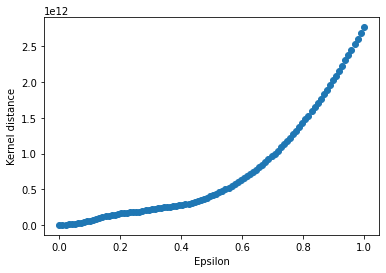

In [199]:
plt.scatter(epss, rkhss)
plt.xlabel("Epsilon")
plt.ylabel("Kernel distance")

In [215]:
epss = np.linspace(0, 0.1, 100)
accuracies = []
for eps in epss:
  test_attack_images = test_example_data + eps*test_example_data.grad.sign()
  test_attack_images = torch.clamp(test_attack_images, 0, 1)

  Kxavx = kernel(train_example_data, test_attack_images, False)[-1,...].T
  scores = Kxavx.matmul(alphas)
  print(scores)
  preds = scores.argmax(axis=1)
  accuracies.append(accuracy_score(test_example_targets, preds))

tensor([[-0.9410, -0.7954, -1.0163,  ..., -1.0959, -1.0539, -1.0276],
        [-1.0303, -0.8795, -0.9884,  ..., -0.9402, -0.4799, -0.6954],
        [-0.8337, -1.0554, -0.7347,  ..., -0.7698, -1.0959, -0.9847],
        ...,
        [-0.8827, -0.9564, -1.0676,  ..., -1.1812, -0.6995, -1.1960],
        [-0.8985,  0.3026, -0.7300,  ..., -0.7949, -0.9323, -0.8184],
        [-1.0696, -1.0478, -1.0445,  ..., -0.4549, -0.6168, -0.6544]],
       grad_fn=<MmBackward>)
tensor([[-0.9404, -0.7949, -1.0153,  ..., -1.0952, -1.0526, -1.0274],
        [-1.0304, -0.8800, -0.9874,  ..., -0.9399, -0.4833, -0.6951],
        [-0.8335, -1.0552, -0.7339,  ..., -0.7692, -1.0955, -0.9843],
        ...,
        [-0.8820, -0.9564, -1.0665,  ..., -1.1813, -0.6984, -1.1954],
        [-0.8977,  0.2987, -0.7277,  ..., -0.7935, -0.9304, -0.8170],
        [-1.0693, -1.0477, -1.0432,  ..., -0.4539, -0.6186, -0.6538]],
       grad_fn=<MmBackward>)
tensor([[-0.9396, -0.7945, -1.0144,  ..., -1.0947, -1.0514, -1.0271],
    

KeyboardInterrupt: ignored

Text(0, 0.5, 'Accuracy')

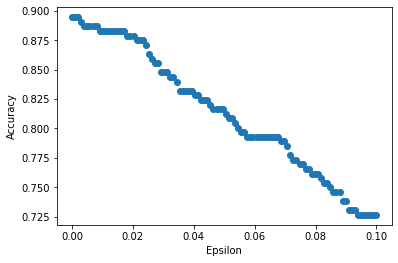

In [214]:
plt.scatter(epss, accuracies)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

### Uncertainty measures


In [223]:
Kavxavx = kernel(test_attack_images, test_attack_images, False)[-1,...].T

variances_adv = torch.diag(Kavxavx - Kxavx.mm(torch.linalg.solve(Kxx, Kxavx.T)))

In [224]:
Kvxvx = kernel(test_example_data, test_example_data, False)[-1,...].T

variances = torch.diag(Kvxvx - Kxvx.mm(torch.linalg.solve(Kxx, Kxvx.T)))

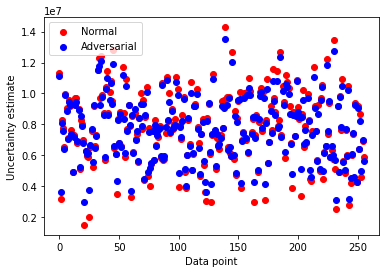

In [230]:
import numpy as np

plt.scatter(np.arange(len(variances)), variances.detach(), c='red', label="Normal")
plt.scatter(np.arange(len(variances_adv)), variances_adv.detach(), c='blue', label="Adversarial")
plt.xlabel('Data point')
plt.ylabel("Uncertainty estimate")
plt.legend()

### Adversarial Image Plots

(-0.5, 27.5, 27.5, -0.5)

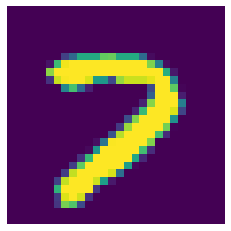

In [ ]:
plt.imshow(test_example_data[0][0].detach())
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

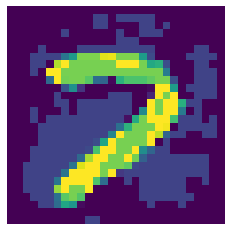

In [ ]:
plt.imshow(test_attack_images[0][0].detach())
plt.axis('off')

In [ ]:
eps = torch.tensor([0.0001, 0.001, 0.01, 0.1])
images_to_show = test_example_data[:4]
test_attack_images_to_show = images_to_show + eps.reshape(-1, 1, 1, 1)*test_example_data.grad.sign()[:4]
test_attack_images_to_show = torch.clamp(test_attack_images_to_show, 0, 1)

(-0.5, 121.5, 31.5, -0.5)

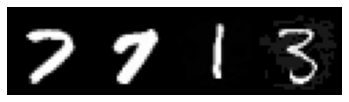

In [ ]:
import torchvision

grid_img = torchvision.utils.make_grid(test_attack_images_to_show, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0), cmap='copper')
plt.axis('off')

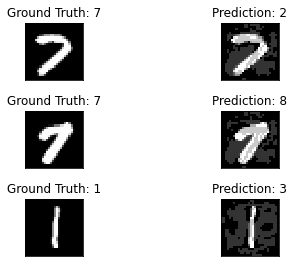

In [ ]:
fig = plt.figure()
for i in range(0, 3):
  plt.subplot(3,2,2*i+1)
  plt.tight_layout()
  plt.imshow(test_example_data[i][0].detach(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(test_example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(3,2,2*i+2)
  plt.tight_layout()
  plt.imshow(test_attack_images[i][0].detach(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(preds[i]))
  plt.xticks([])
  plt.yticks([])